In [1]:
import re
import numpy as np
import pandas as pd
import time
from random import random,randint
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read Amazon and Mercado Libre Data

In [18]:
data_meli = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_meli/data_all_3.csv")
print(data_meli.shape)
for i in range(4,8):
  data_meli = pd.concat([data_meli, pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_meli/data_all_"+str(i)+".csv")])
  print(data_meli.shape)
data_meli.drop('Unnamed: 0', axis = 1, inplace = True)
data_meli.reset_index(drop = True, inplace = True)
data_meli["platform"] = "Mercado Libre"

(457, 23)
(929, 23)
(1404, 23)
(1877, 23)
(2347, 23)


In [19]:
data_meli.loc[0]

link             https://click1.mercadolibre.com.mx/mclics/clic...
title            Bocinas Bluetooth Portatil Altavoz Recargables...
n_reviews                                                       38
n_stars                                                        4.8
l_tree                                                           3
categories       ['Electrónica, Audio y Video', 'Audio', 'Bocin...
stock                                                           17
new                                                           True
sales_1                                              +100 vendidos
recommended                                                      0
free_delivery                                                 True
seller_name                                                    NaN
seller_link              https://perfil.mercadolibre.com.mx/EMUAEL
seller_sales                                                +10mil
ch_vec                                                        

In [22]:
data_amazon = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_all.csv")
print(data_amazon.shape)
for i in range(2,6):
  data_amazon = pd.concat([data_amazon, pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/data_amazon/amazon_all_"+str(i)+".csv")]).reset_index(drop = True)
  print(data_amazon.shape)
data_amazon["platform"] = "Amazon"

(379, 11)
(760, 11)
(1137, 11)
(1513, 11)
(1889, 11)


In [23]:
data_amazon.loc[0]

page                                                             1
rank                                                             1
title                   JBL Flip 6 Bocina Portátil Bluetooth Negro
link             /JBL-Bocina-Port%C3%A1til-Bluetooth-Negro/dp/B...
n_stars                                                        4.8
n_reviews                                                   6408.0
curr_price                                                  1852.0
fast_delivery                                                 True
prime                                                         True
free_delivery                                                 True
date                                                      20230706
platform                                                    Amazon
Name: 0, dtype: object

In [27]:
data_amazon.date.unique()

array([20230706, 20230707, 20230708, 20230710, 20230711])

## Data transformation

In [28]:
#Get dummies for benefits
meli_benefits = []
for ben_vec in data_meli.benefits:
  for benefit in re.sub("[\[\]'.]", "", ben_vec).split(","):
    meli_benefits.append(benefit.strip())
meli_benefits = list(set(meli_benefits))
data_meli["devolucion_gratis"] = data_meli["benefits"].apply(lambda x: meli_benefits[0] in x)
data_meli["mercado_puntos"] = data_meli["benefits"].apply(lambda x: meli_benefits[1] in x)
data_meli["compra_protegida"] = data_meli["benefits"].apply(lambda x: meli_benefits[2] in x)

In [29]:
#Get dummies for some characteristics

data_meli["bluetooth"] = data_meli["ch_vec"].apply(lambda x: "bluetooth" in x)
data_meli["usb_c"] = data_meli["ch_vec"].apply(lambda x: "USB-C" in x)
data_meli["bateria_recargable"] = data_meli["ch_vec"].apply(lambda x: "Batería recargable" in x)
data_meli["woofer"] = data_meli["ch_vec"].apply(lambda x: "woofer" in x)
data_meli["radio"] = data_meli["ch_vec"].apply(lambda x: "radio" in x)
data_meli["portatil"] = data_meli["ch_vec"].apply(lambda x: "portatil" in x)

In [30]:
#Power in watts
potencia = []
for ch in data_meli.ch_vec:
  if "Potencia de" in ch:
    potencia.append(float(ch[ch.find("Potencia de")+12:ch.find("W.")]))
  else:
    potencia.append(0)
data_meli["potencia_w"] = potencia

In [31]:
data_amazon["title"] = data_amazon["title"].str.lower().apply(lambda x: x.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u"))
data_meli["title"] = data_meli["title"].str.lower().apply(lambda x: x.replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u"))

data_amazon["bluetooth"] = data_amazon["title"].apply(lambda x: ("bluetooth" in x))
data_amazon["bateria_recargable"] = data_amazon["title"].apply(lambda x: ("bateria" in x))
data_amazon["portatil"] = data_amazon["title"].apply(lambda x: ("portatil" in x))

In [32]:
cols_in_common = ['page', 'rank', 'title', 'link', 'n_stars', 'n_reviews', 'curr_price',
       'free_delivery', 'platform', 'bluetooth','bateria_recargable', 'portatil', 'date']
data_all = pd.concat([data_meli[cols_in_common], data_amazon[cols_in_common]]).reset_index(drop = True)

In [33]:
brands = ["sony", "alexa", "amazon", "jbl", "bose", "yamaha", "lg", "echo", "kaiser", "logitech", "tlc", "sonos", "hisense", "samsung", "xiaomi", ]
data_all["known_brand"] = data_all.title.apply(lambda x: any([br in x for br in brands]))

In [34]:
data_all.groupby(by = ["platform"]).describe().transpose()

platform                Amazon  Mercado Libre
page       count  1.889000e+03   2.347000e+03
           mean   3.772896e+00   5.438432e+00
           std    1.893842e+00   2.872827e+00
           min    1.000000e+00   1.000000e+00
           25%    2.000000e+00   3.000000e+00
           50%    4.000000e+00   5.000000e+00
           75%    5.000000e+00   8.000000e+00
           max    7.000000e+00   1.000000e+01
rank       count  1.889000e+03   2.347000e+03
           mean   1.963134e+02   2.687248e+02
           std    1.130848e+02   1.566598e+02
           min    1.000000e+00   1.000000e+00
           25%    9.700000e+01   1.340000e+02
           50%    1.980000e+02   2.670000e+02
           75%    2.940000e+02   4.045000e+02
           max    3.940000e+02   5.520000e+02
n_stars    count  1.889000e+03   2.347000e+03
           mean   4.123928e+00   1.375458e+00
           std    1.158676e+00   2.106607e+00
           min    0.000000e+00   0.000000e+00
           25%    4.100000e+00   0.000000e+00
           50%    4.400000e+00   0.000000e+00
           75%    4.700000e+00   4.200000e+00
           max    5.000000e+00   5.000000e+00
n_reviews  count  1.889000e+03   2.347000e+03
           mean   3.455318e+03   5.806817e+01
           std    1.237336e+04   6.658735e+02
           min    0.000000e+00   0.000000e+00
           25%    1.900000e+01   0.000000e+00
           50%    1.780000e+02   0.000000e+00
           75%    2.021000e+03   4.000000e+00
           max    2.088050e+05   1.990700e+04
curr_price count  1.889000e+03   2.347000e+03
           mean   1.941420e+03   3.995599e+03
           std    2.396207e+03   7.086002e+03
           min    8.900000e+01   4.800000e+01
           25%    4.490000e+02   5.790000e+02
           50%    9.890000e+02   1.199000e+03
           75%    2.758000e+03   4.277000e+03
           max    2.184900e+04   6.637500e+04
date       count  1.889000e+03   2.347000e+03
           mean   2.023071e+07   2.023071e+07
           std    1.854668e+00   1.849069e+00
           min    2.023071e+07   2.023071e+07
           25%    2.023071e+07   2.023071e+07
           50%    2.023071e+07   2.023071e+07
           75%    2.023071e+07   2.023071e+07
           max    2.023071e+07   2.023071e+07

In [35]:
data_aux = data_all.groupby(by = ["title", "platform","date"]).count()
data_aux[data_aux.page >1].shape

(406, 11)

In [36]:
data_all = data_all.drop_duplicates(subset = ['title','platform','date'])

In [37]:
data_aux = data_all.groupby(by = ["title","platform"]).count()
data_aux[data_aux.page<4]

,,page,rank,link,n_stars,n_reviews,curr_price,free_delivery,bluetooth,bateria_recargable,portatil,date,known_brand
title,platform,,,,,,,,,,,,
bafle 15audiobahn procesamiento de señales digitales asd15,Mercado Libre,2,2,2,2,2,2,2,2,2,2,2,2
"1 hora bocina bluetooth portatil 5.3 portatil altavoz bluetooth portatil inalambrica con sonido estereo micro sd usb radio fm, ipx3 a prueba de agua, compatible con iphone/ipad/android/tablet, negro",Amazon,3,3,3,3,3,3,3,3,3,3,3,3
1 par de bocinas para portatiles 925306-001 izquierdo,Mercado Libre,1,1,1,1,1,1,1,1,1,1,1,1
2 suspencion de caucho bocina audioban bazooka 12p+pegamento,Mercado Libre,1,1,1,1,1,1,1,1,1,1,1,1
4 pz bocina para plafon 6 1/2 10w 8 ohms 065-828 t3324,Mercado Libre,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
xiaomi - altavoz bluetooth portatil mi gris,Amazon,1,1,1,1,1,1,1,1,1,1,1,1
"yabely led bocina bluetooth portatil, altavoz bluetooth inalambrico, mini altavoz inalambrico,microfono incorporado con luz led, funcion de llamada manos libres, micro sd, tarjeta tf",Amazon,1,1,1,1,1,1,1,1,1,1,1,1
yamaha bafle para media intemperie nsaw190 par blanco,Mercado Libre,1,1,1,1,1,1,1,1,1,1,1,1


## Data cleaning

In [38]:
data_all = data_all[data_all.curr_price<data_all.curr_price.quantile(0.9)]

In [45]:
data_meli = data_meli[data_meli.curr_price<data_meli.curr_price.quantile(0.9)]

In [46]:
data_amazon = data_amazon[data_amazon.curr_price<data_amazon.curr_price.quantile(0.9)]

## Data Visualization

### Single variable exploration

In [41]:
sbn.set_palette("colorblind6")

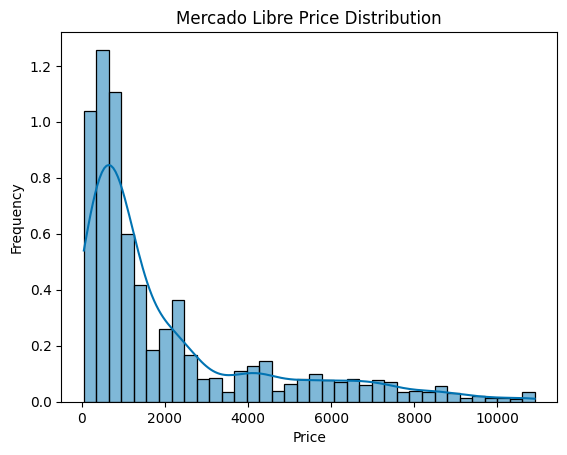

In [47]:
fig1 = sbn.histplot(data_meli, x = "curr_price", stat = "frequency", kde = True)
fig1.set(title='Mercado Libre Price Distribution', xlabel = "Price")
plt.show()

<Axes: title={'center': 'Mercado Libre Sales'}, xlabel='Sales', ylabel='count'>

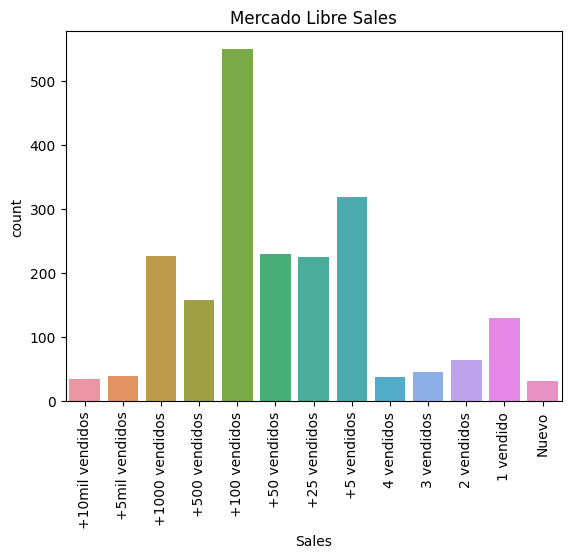

In [48]:
fig2 = sbn.countplot(data_meli, x = "sales_1", order = ['+10mil vendidos','+5mil vendidos','+1000 vendidos','+500 vendidos',
                                                        '+100 vendidos','+50 vendidos','+25 vendidos', '+5 vendidos',
                                                        '4 vendidos','3 vendidos','2 vendidos', '1 vendido', 'Nuevo'])
fig2.set(title='Mercado Libre Sales', xlabel = "Sales")
fig2.tick_params(axis='x', rotation=90)
fig2

<Axes: title={'center': 'Mercado Libre Stock Distribution'}, xlabel='Stock', ylabel='Frequency'>

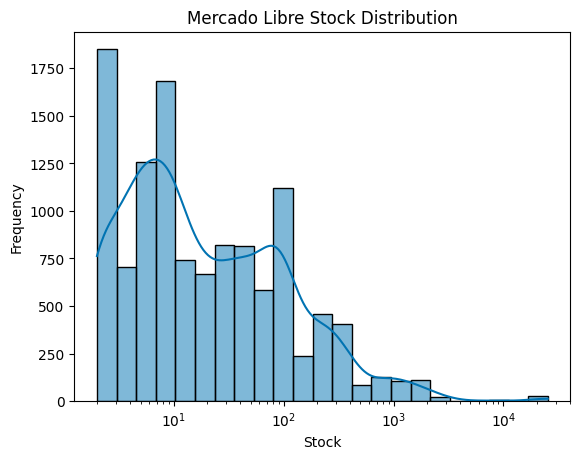

In [49]:
fig3 = sbn.histplot(data_meli, x = "stock", stat = "frequency", kde = True, log_scale=True)
fig3.set(title='Mercado Libre Stock Distribution', xlabel = "Stock")
fig3

<Axes: title={'center': 'Mercado Libre Stock Distribution - Truncated'}, xlabel='Stock', ylabel='Frequency'>

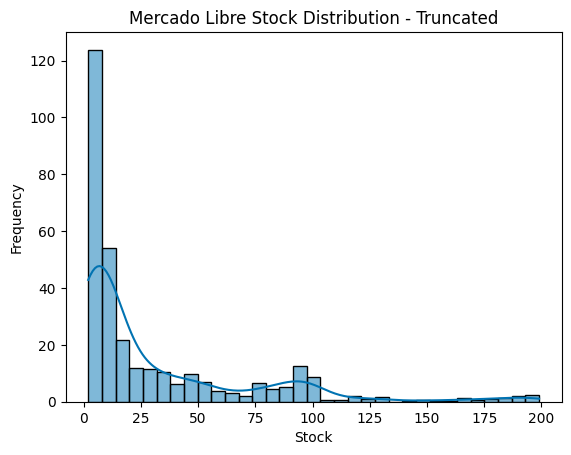

In [50]:
fig4 = sbn.histplot(data_meli[data_meli.stock <200], x = "stock", stat = "frequency", kde = True)
fig4.set(title='Mercado Libre Stock Distribution - Truncated', xlabel = "Stock")
fig4

<Axes: title={'center': 'Consumption (W) distribution'}, xlabel='Consumption', ylabel='Frequency'>

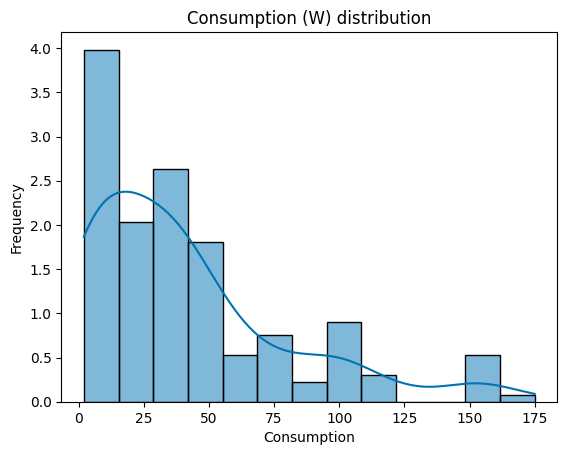

In [51]:
fig5 = sbn.histplot(data_meli[(data_meli.potencia_w>0) & (data_meli.potencia_w<200) ], x = "potencia_w", stat = "frequency", kde = True)
fig5.set(title='Consumption (W) distribution', xlabel = "Consumption")
fig5

<Axes: title={'center': 'Number of Reviews distribution'}, xlabel='Reviews', ylabel='Frequency'>

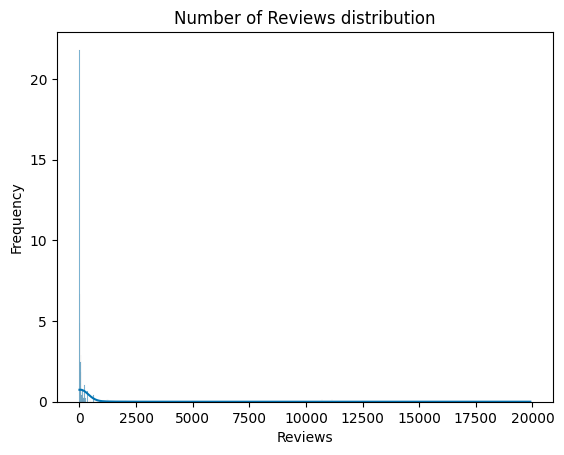

In [52]:
fig6 = sbn.histplot(data_meli[data_meli.n_reviews>0], x = "n_reviews", stat = "frequency", kde = True)
fig6.set(title='Number of Reviews distribution', xlabel = "Reviews")
fig6

<Axes: title={'center': 'Number of Reviews distribution'}, xlabel='Reviews', ylabel='Frequency'>

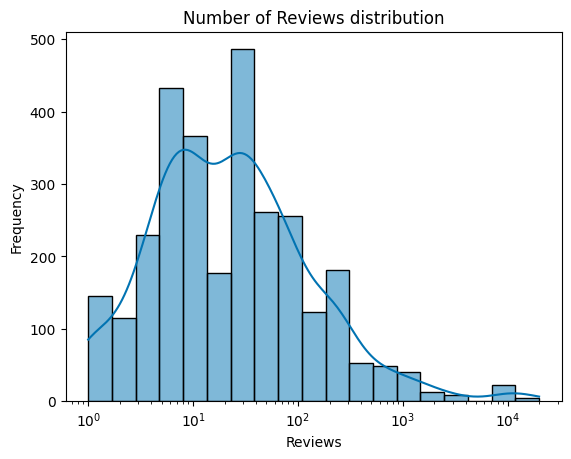

In [53]:
fig7 = sbn.histplot(data_meli[data_meli.n_reviews>0], x = "n_reviews", stat = "frequency", log_scale = True, kde = True)
fig7.set(title='Number of Reviews distribution', xlabel = "Reviews")
fig7

<Axes: title={'center': 'Mercado Libre Product Rating'}, xlabel='Rating', ylabel='Frequency'>

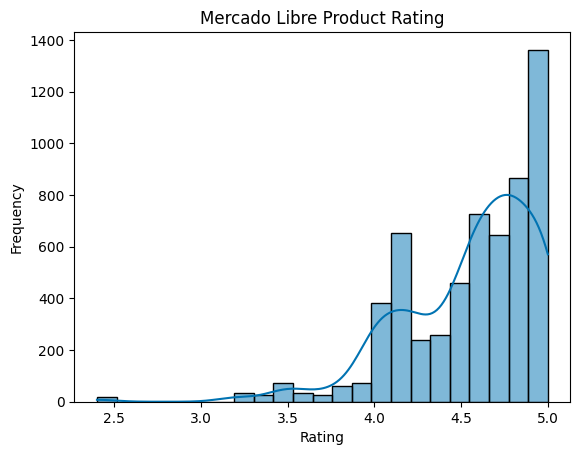

In [54]:
fig8 = sbn.histplot(data_meli[data_meli.n_stars>0], x = "n_stars", stat = "frequency", kde = True)
fig8.set(title='Mercado Libre Product Rating', xlabel = "Rating")
fig8

<Axes: title={'center': 'Price Distribution'}, xlabel='Price', ylabel='Density'>

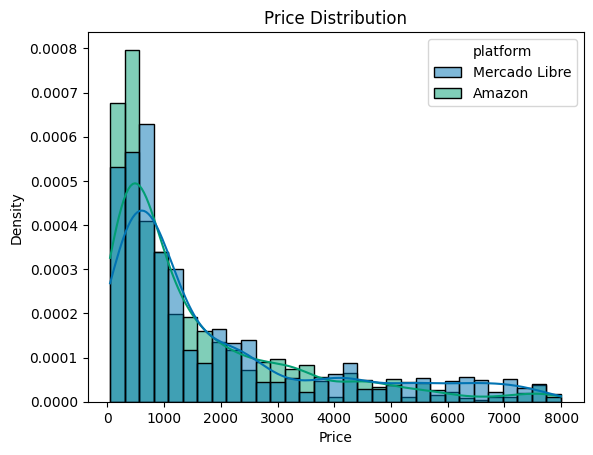

In [55]:
fig_all1 = sbn.histplot(data_all, x = "curr_price", stat = "density", hue= "platform", kde = True, common_norm = False)
fig_all1.set(title='Price Distribution', xlabel = "Price")
fig_all1

<Axes: title={'center': 'Stars Distribution'}, xlabel='Mean Rating', ylabel='Density'>

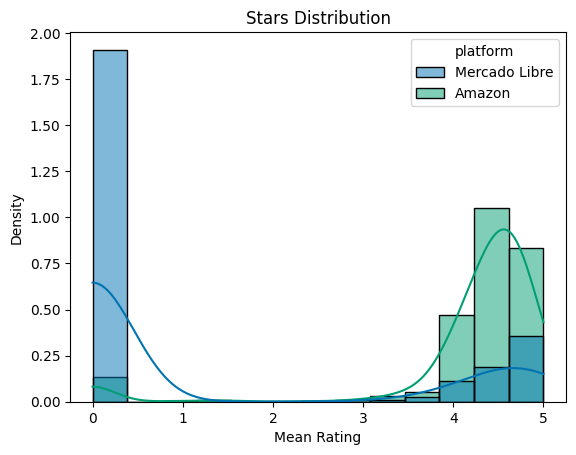

In [57]:
fig_all2 = sbn.histplot(data_all, x = "n_stars", stat = "density", hue= "platform", kde = True, common_norm = False)
fig_all2.set(title='Stars Distribution', xlabel = "Mean Rating")
fig_all2

<Axes: title={'center': 'Review Count Distribution'}, xlabel='Review Count', ylabel='Frequency'>

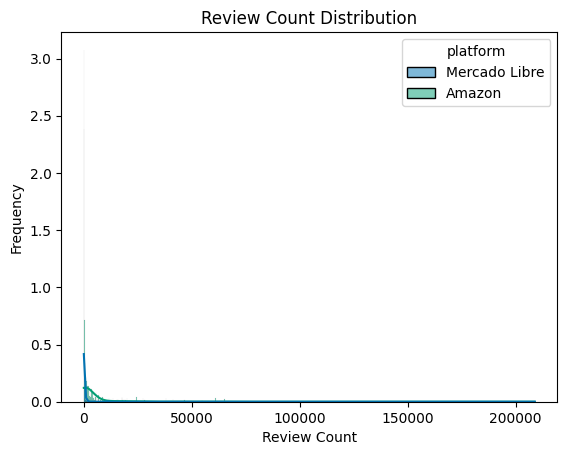

In [58]:
fig_all3 = sbn.histplot(data_all[data_all.n_reviews>0], x = "n_reviews", stat = "frequency", hue= "platform", kde = True, common_norm = False)
fig_all3.set(title='Review Count Distribution', xlabel = "Review Count")
fig_all3

<Axes: title={'center': 'Review Count Distribution'}, xlabel='Review Count', ylabel='Frequency'>

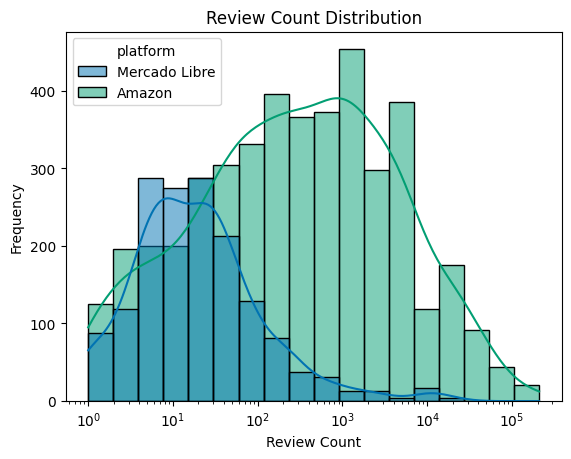

In [59]:
fig_all3 = sbn.histplot(data_all[data_all.n_reviews>0], x = "n_reviews", stat = "frequency", hue= "platform", kde = True, common_norm = False, log_scale = True)
fig_all3.set(title='Review Count Distribution', xlabel = "Review Count")
fig_all3

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: title={'center': 'Free Delivery Option'}, xlabel='Free delivery', ylabel='Density'>

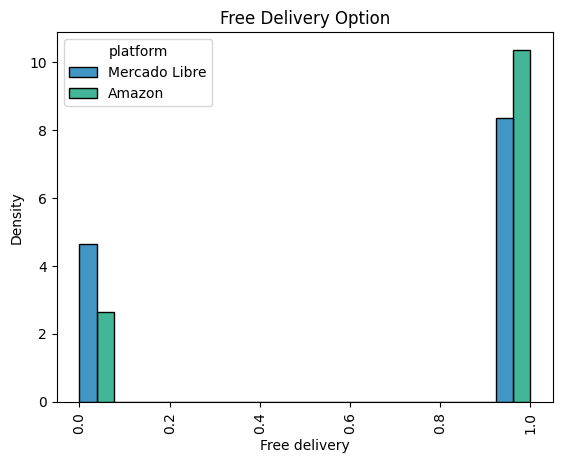

In [60]:
fig_all4 = sbn.histplot(data_all, x = "free_delivery", hue = "platform",stat = 'density', multiple = "dodge", common_norm=False)
fig_all4.set(title='Free Delivery Option', xlabel = "Free delivery")
fig_all4.tick_params(axis='x', rotation=90)
fig_all4

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


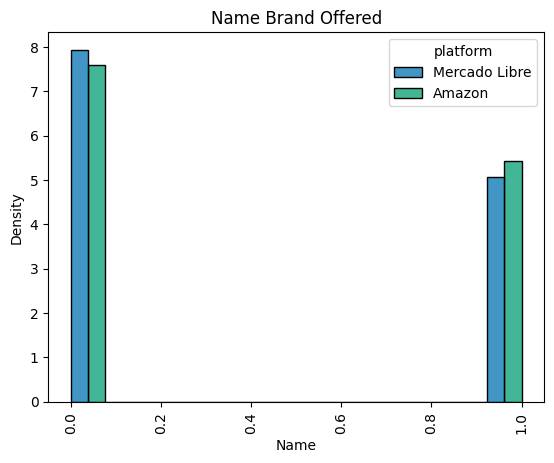

In [62]:
fig_all5 = sbn.histplot(data_all, x = "known_brand", hue = "platform",stat = 'density', multiple = "dodge", common_norm=False)
fig_all5.set(title='Name Brand Offered', xlabel = "Name")
fig_all5.tick_params(axis='x', rotation=90)
plt.show()

### Interaction Visualization

<Axes: title={'center': 'Mercado Libre Sales vs Price'}, xlabel='Sales', ylabel='Price'>

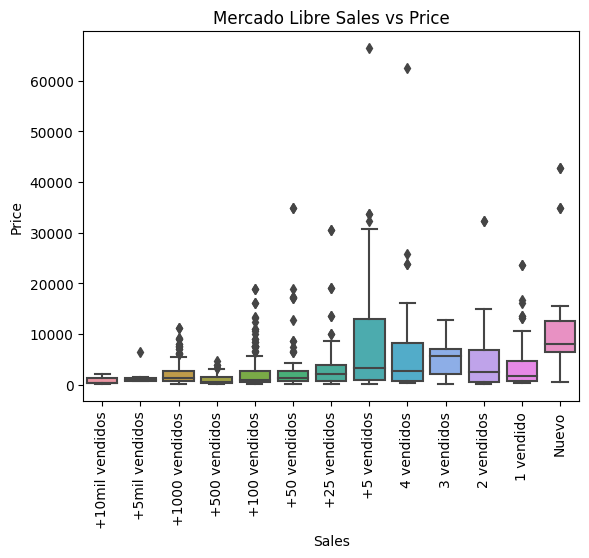

In [ ]:
fig9 = sbn.boxplot(data_meli, x = "sales_1", y = "curr_price", order = ['+10mil vendidos','+5mil vendidos','+1000 vendidos','+500 vendidos',
                                                        '+100 vendidos','+50 vendidos','+25 vendidos', '+5 vendidos',
                                                        '4 vendidos','3 vendidos','2 vendidos', '1 vendido', 'Nuevo'])
fig9.set(title='Mercado Libre Sales vs Price', xlabel = "Sales", ylabel = "Price")
fig9.tick_params(axis='x', rotation=90)
fig9

<Axes: title={'center': 'Mercado Libre Stock vs price'}, xlabel='Stock', ylabel='Price'>

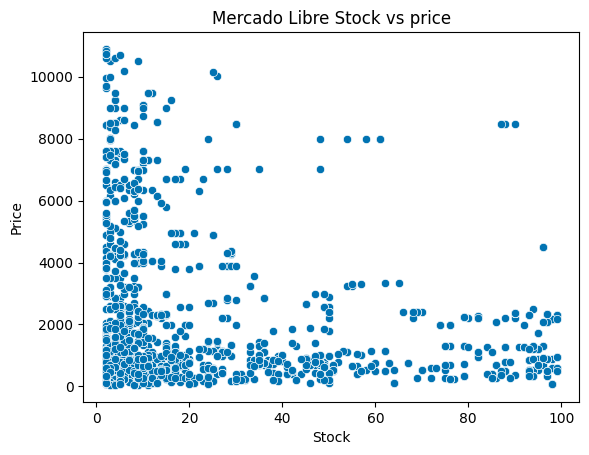

In [63]:
fig10 = sbn.scatterplot(data_meli[data_meli.stock<100], x = "stock", y = "curr_price")
fig10.set(title='Mercado Libre Stock vs price', xlabel = "Stock", ylabel = "Price")
fig10

<Axes: title={'center': 'Mercado Libre Stock vs price'}, xlabel='Stock', ylabel='Price'>

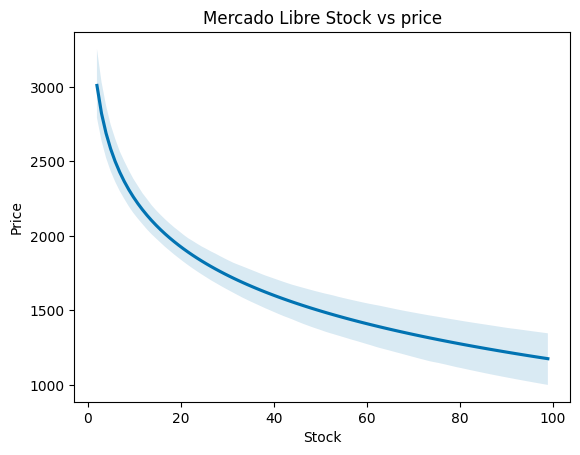

In [64]:
fig10 = sbn.regplot(data_meli[data_meli.stock<100], x = "stock", y = "curr_price", logx = True, scatter = False)
fig10.set(title='Mercado Libre Stock vs price', xlabel = "Stock", ylabel = "Price")
fig10

<Axes: title={'center': 'Mercado Libre New vs Used Prices'}, xlabel='New', ylabel='Price'>

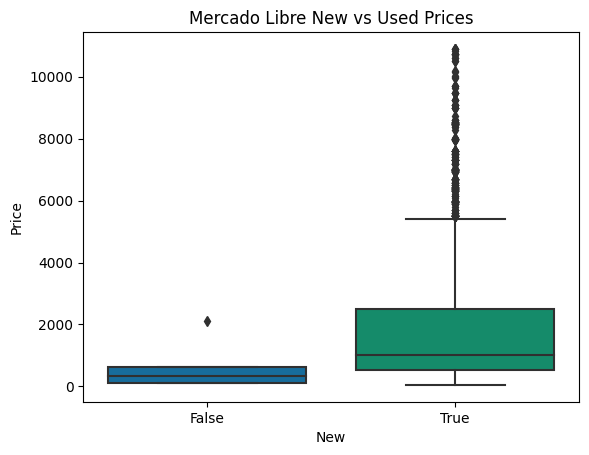

In [72]:
fig11 = sbn.boxplot(data_meli, x = "new", y = "curr_price")
fig11.set(title='Mercado Libre New vs Used Prices', xlabel = "New", ylabel = "Price")
fig11

<Axes: title={'center': 'Mercado Libre Recomended Product Prices'}, xlabel='Recommended', ylabel='Price'>

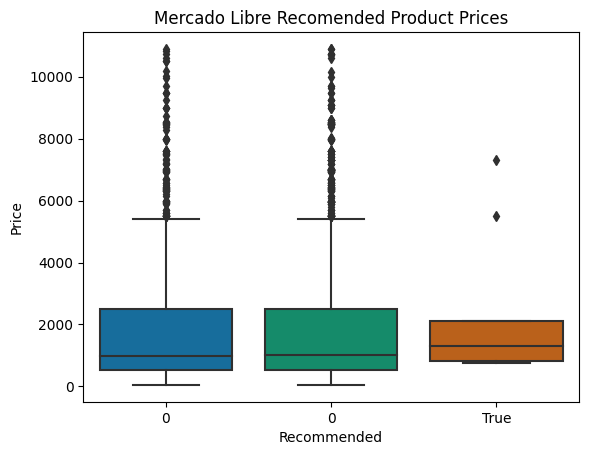

In [66]:
fig12 = sbn.boxplot(data_meli, x = "recommended", y = "curr_price")
fig12.set(title='Mercado Libre Recomended Product Prices', xlabel = "Recommended", ylabel = "Price")
fig12

<Axes: title={'center': 'Mercado Libre Free vs Costly delivery Prices'}, xlabel='Free Delivery', ylabel='Price'>

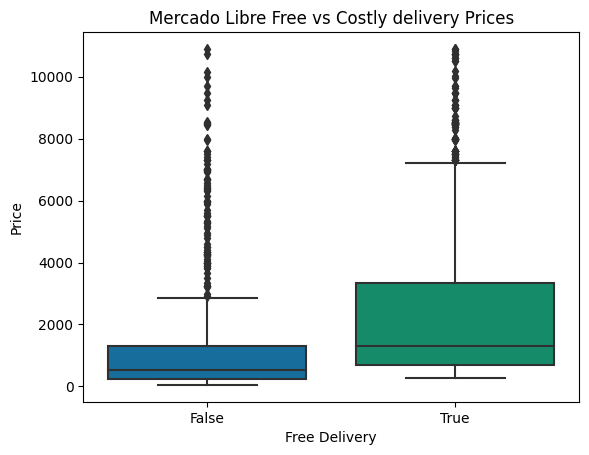

In [67]:
fig13 = sbn.boxplot(data_meli, x = "free_delivery", y = "curr_price")
fig13.set(title='Mercado Libre Free vs Costly delivery Prices', xlabel = "Free Delivery", ylabel = "Price")
fig13

<Axes: title={'center': 'Mercado Libre Free vs Costly Returns Prices'}, xlabel='Free returns', ylabel='Price'>

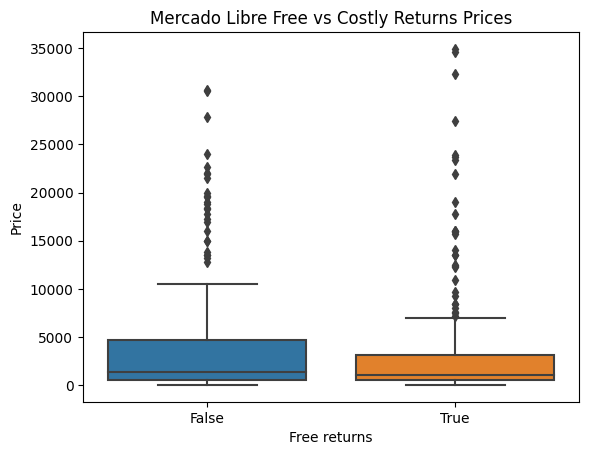

In [ ]:
fig14 = sbn.boxplot(data_meli, x = "devolucion_gratis", y = "curr_price")
fig14.set(title='Mercado Libre Free vs Costly Returns Prices', xlabel = "Free returns", ylabel = "Price")
fig14

<Axes: title={'center': 'Amazon Price Distribution'}, xlabel='Price', ylabel='Frequency'>

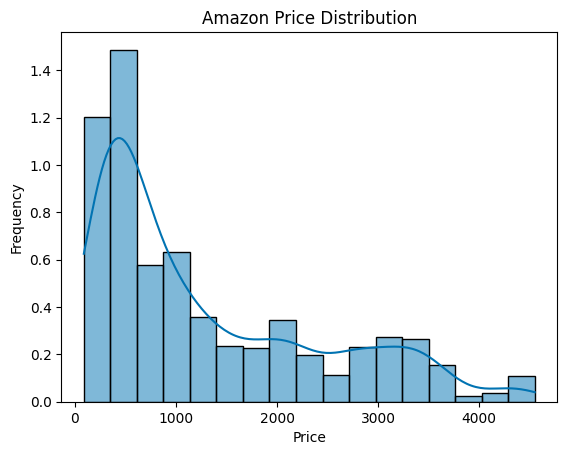

In [70]:
fig2 = sbn.histplot(data_amazon, x = "curr_price", stat = "frequency", kde = True)
fig2.set(title='Amazon Price Distribution', xlabel = "Price")
fig2

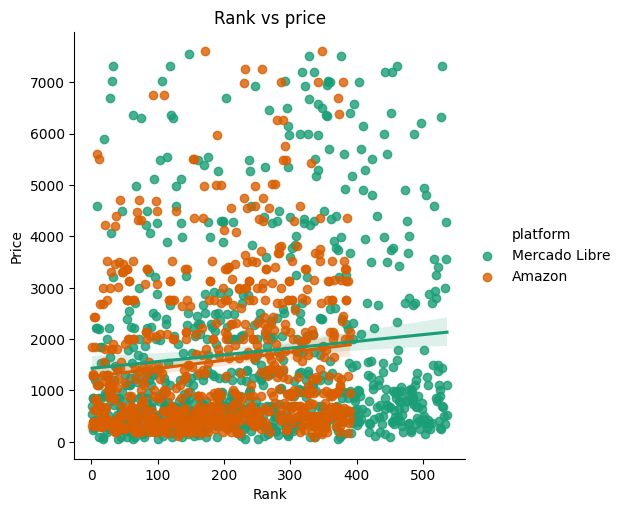

In [ ]:
fig_all5 = sbn.lmplot(data_all, x = "rank", y = "curr_price", hue = "platform")
fig_all5.set(title='Rank vs price', xlabel = "Rank", ylabel = "Price")
fig_all5

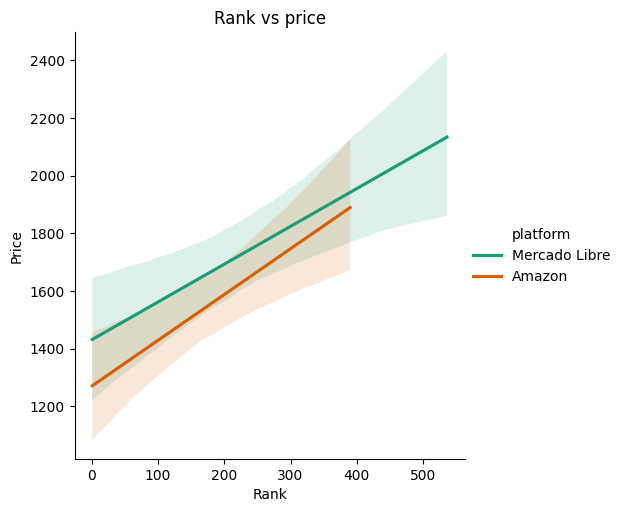

In [ ]:
fig_all6 = sbn.lmplot(data_all, x = "rank", y = "curr_price", hue = "platform", scatter = False)
fig_all6.set(title='Rank vs price', xlabel = "Rank", ylabel = "Price")
fig_all6

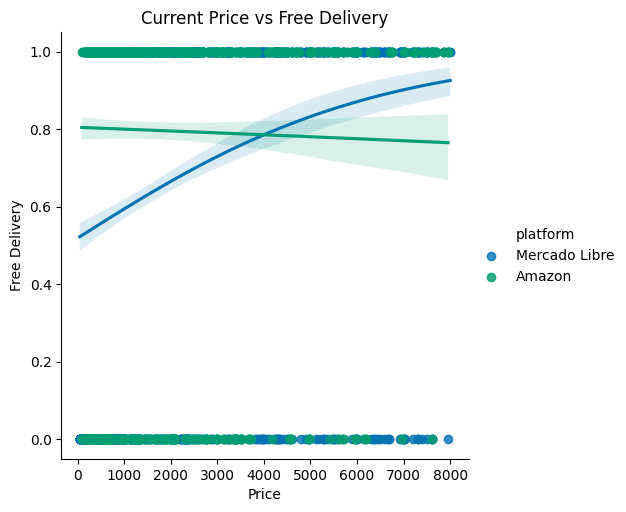

In [68]:
fig_all5 = sbn.lmplot(data_all, x = "curr_price", y = "free_delivery", hue = "platform", logistic = True)
fig_all5.set(title='Current Price vs Free Delivery', xlabel = "Price", ylabel = "Free Delivery")
fig_all5

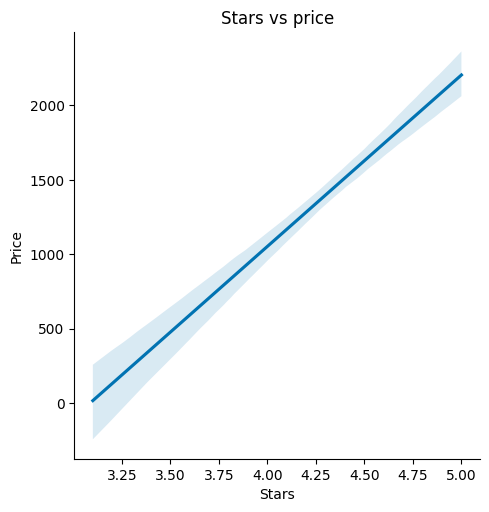

In [84]:
fig_all6 = sbn.lmplot(data_all[data_all.n_stars > 3 ], x = "n_stars", y = "curr_price", scatter = False)
fig_all6.set(title='Stars vs price', xlabel = "Stars", ylabel = "Price")
plt.show()

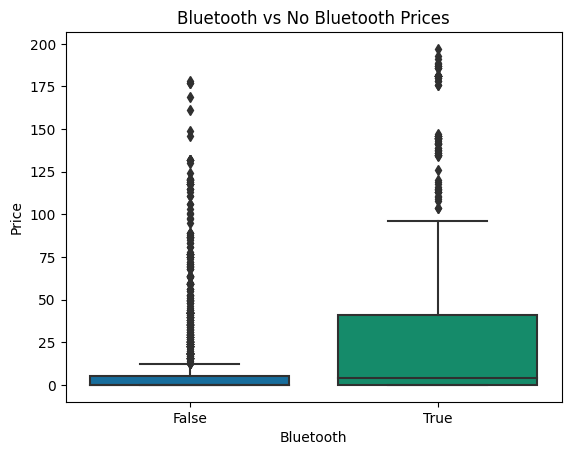

In [95]:
fig14 = sbn.boxplot(data_all[data_all.n_reviews < 200], x = "bluetooth", y = "n_reviews")
fig14.set(title='Bluetooth vs No Bluetooth Prices', xlabel = "Bluetooth", ylabel = "Price")
plt.show()

In [73]:
data_all.columns

Index(['page', 'rank', 'title', 'link', 'n_stars', 'n_reviews', 'curr_price',
       'free_delivery', 'platform', 'bluetooth', 'bateria_recargable',
       'portatil', 'date', 'known_brand'],
      dtype='object')

## Reduced Forms

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
y1 = np.array(data_meli.sales_1.str.replace("Nuevo", "0").str.replace("mil", "000").str.strip("+ vendidos").astype(float))

In [ ]:
data_meli.columns

Index(['link', 'title', 'n_reviews', 'n_stars', 'l_tree', 'categories',
       'stock', 'new', 'sales_1', 'recommended', 'free_delivery',
       'seller_name', 'seller_link', 'seller_sales', 'ch_vec', 'n_benefits',
       'benefits', 'curr_price', 'page', 'rank', 'title_initial', 'platform',
       'devolucion_gratis', 'mercado_puntos', 'compra_protegida', 'porencia_w',
       'potencia_w'],
      dtype='object')

In [ ]:
X = data_meli[["n_reviews", "n_stars", "stock", "new", "recommended", "free_delivery", "n_benefits", "curr_price", "page", "rank", "devolucion_gratis", "mercado_puntos", "compra_protegida", "potencia_w"]]
X["recommended"] = X["recommended"] == "True"
X = np.array(X.astype(float))
X = sm.add_constant(X)

<ipython-input-342-a5295bae45f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["recommended"] = X["recommended"] == "True"


In [ ]:
X = data_meli[["stock", "new", "free_delivery", "n_benefits", "curr_price", "page", "rank"]]
X = np.array(X.astype(float))
X = sm.add_constant(X)

In [ ]:
model = sm.OLS(y1, X)

In [ ]:
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.162
Date:                Tue, 04 Jul 2023   Prob (F-statistic):              0.323
Time:                        02:19:25   Log-Likelihood:                -3885.8
No. Observations:                 472   AIC:                             7788.
Df Residuals:                     464   BIC:                             7821.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.6609    671.563      0.159      0.8